# Credit Card Fraud Detection - Anomaly detection of fraudulent transactions

![Credit Card Fraud Detection](https://storage.googleapis.com/kaggle-datasets-images/310/684/3503c6c827ca269cc00ffa66f2a9c207/dataset-cover.jpg)

Credit card fraud is a significant issue that impacts both companies and customers. This theme is quite important nowadays since online transactions are at an all-time high, making fraud detection a crucial part of keeping financial systems secure. 

For this project, I chose the [Credit Card Fraud Detection Dataset](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data) to explore anomaly detection methods that can effectively distinguish between normal and abnormal (fraudulent) transactions. 

The code is divided in three parts:
1.  Dataset analysis
2.  GMM baseline implementation
3.  Autoencoder implementation

In [2]:
# Libraries imports
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import mixture

from tensorflow.keras import optimizers
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping


## 1. Dataset analysis

Before proceeding with the implementation of the models it is good practice to analyze the data.


In [20]:
# Upload the dataset
df = pd.read_csv("./data/creditcard.csv")

print(df.shape)
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


It is possible to see that the dataset is composed by only numerical input variables, resulting from a PCA transformation, where each row corresponds to an individual transaction.

Principal Component Analysis (PCA) is a dimensionality reduction technique that transforms a dataset into a set of orthogonal principal components, maximizing variance and retaining the most important features while reducing the overall number of dimensions.

In the specific, we have:
- **Features V1 to V28**: Principal components derived from PCA, representing transformed features that capture the essential variance in the data.
  
- **Time**: The number of seconds elapsed between each transaction.
  
- **Amount**: The monetary value of each transaction.
  
- **Class**: The response variable indicating whether the transaction is fraudulent (1) or legitimate (0).

Now, it is possible to analyze even further: by plotting some components, it is possible to check the distributions of the fraudulent and normal transactions.
  


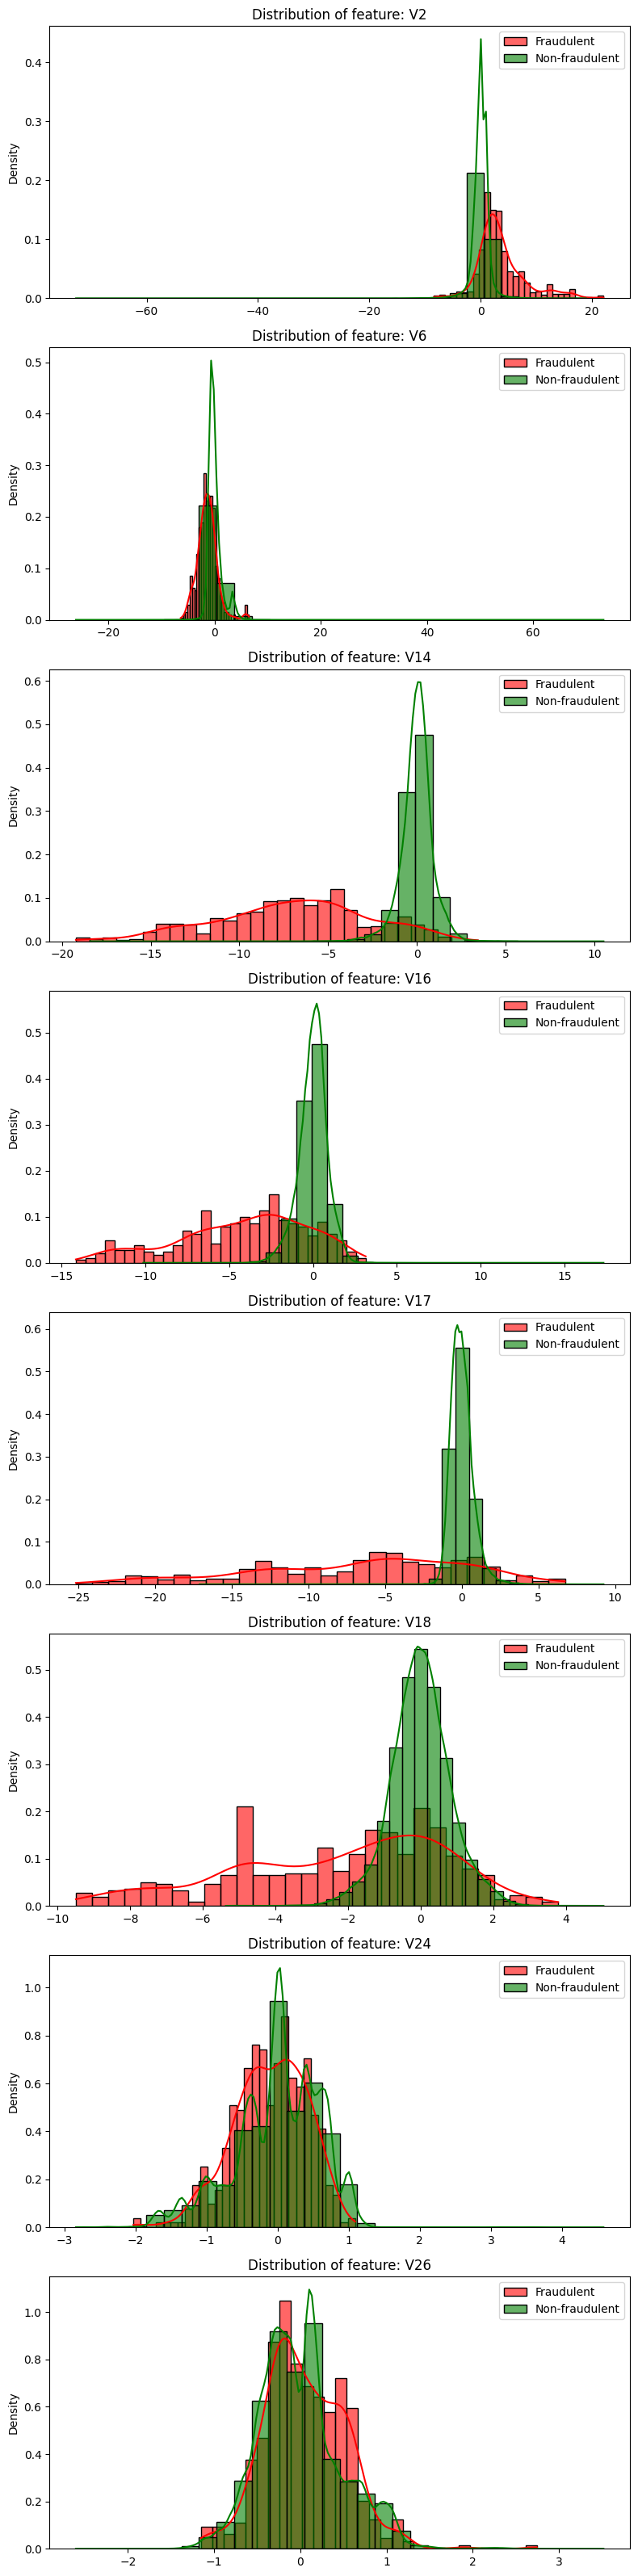

In [4]:
# Let's plot some components
column_names = ['V2','V6', 'V14', 'V16', 'V17', 'V18', 'V24', 'V26']
nplots = np.size(column_names)

plt.figure(figsize=(8, 4 * nplots))
gs = gridspec.GridSpec(nplots, 1)

for i, feat in enumerate(column_names):
    ax = plt.subplot(gs[i])
    sns.histplot(df[feat][df.Class == 1], bins=30, kde=True, color='red', label='Fraudulent', stat='density', alpha=0.6)
    
    sns.histplot(df[feat][df.Class == 0], bins=30, kde=True, color='green', label='Non-fraudulent', stat='density', alpha=0.6)
    
    ax.legend(loc='best')
    ax.set_xlabel('')
    ax.set_title('Distribution of feature: ' + feat)

plt.tight_layout()
plt.show()

The previous graphs show that some components have huge overlaps and unclear distinction over the normal and fraudulent transaction.

To address this issue, it was decided to simplify the dataset by using Randomm Forest to find the best features.

In [5]:
X = df.drop(['Time', 'Amount', 'Class'], axis=1)
y = df['Class']

# Find an train a Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

RandomForestClassifier(random_state=42)

In [6]:
# Obtain the feature importance
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Select the best features (with less overlap) 
selected_features = feature_importances.head(5)['Feature'].tolist()
selected_features.append('Class')  

df_selected = df[selected_features]
print(df_selected.head())

        V17       V14       V12       V10       V16  Class
0  0.207971 -0.311169 -0.617801  0.090794 -0.470401      0
1 -0.114805 -0.143772  1.065235 -0.166974  0.463917      0
2  1.109969 -0.165946  0.066084  0.207643 -2.890083      0
3 -0.684093 -0.287924  0.178228 -0.054952 -1.059647      0
4 -0.237033 -1.119670  0.538196  0.753074 -0.451449      0


In [7]:
simplified_list = sorted(df_selected.columns.to_list())
print(simplified_list)

['Class', 'V10', 'V12', 'V14', 'V16', 'V17']


In [21]:
# Simplify the dataset
df_simplified = df[simplified_list]

df_simplified.head()

,Class,V10,V12,V14,V16,V17
0,0,0.090794,-0.617801,-0.311169,-0.470401,0.207971
1,0,-0.166974,1.065235,-0.143772,0.463917,-0.114805
2,0,0.207643,0.066084,-0.165946,-2.890083,1.109969
3,0,-0.054952,0.178228,-0.287924,-1.059647,-0.684093
4,0,0.753074,0.538196,-1.119670,-0.451449,-0.237033


Then the dataset is Normalized

In [22]:
# Normalize the data
def normalize(df, class_list):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    result['Class'] = class_list
    return result


df_class = df_simplified['Class']
df_normalized = normalize(df_simplified.drop(["Class"], axis=1), df_class)

df_normalized.head()

,V10,V12,V14,V16,V17,Class
0,0.510600,0.680908,0.635591,0.434392,0.737173,0
1,0.505267,0.744342,0.641219,0.464105,0.727794,0
2,0.513018,0.706683,0.640473,0.357443,0.763381,0
3,0.507585,0.710910,0.636372,0.415653,0.711253,0
4,0.524303,0.724477,0.608406,0.434995,0.724243,0


Another important aspect of this dataset is the fact that it is highly unbalanced.

In fact, it is possible to see that the number of normal transactions is significantly higher than fraudulent ones .

In [23]:
# Divide the normal data from the fraudulent ones
normal = df_simplified[df.Class == 0]
fraud = df_simplified[df.Class == 1]
print("The initial normal dataset has this shape:", normal.shape)
print("The fraudulent dataset has this shape:", fraud.shape)

The initial normal dataset has this shape: (284315, 6)
The fraudulent dataset has this shape: (492, 6)


Because of this it was decided to divide the normal dataset in two:
*   the test dataset, that contains a ratio of 3:1 (three normal transaction each fraudulent one)
*   the train dataset, that contains the rest of the normal transactions

In this way it was possible to create a balanced normal test dataset.

In [24]:
RATIO = int(len(fraud) * 3)

normal_train = normal.iloc[RATIO:]
normal_test = normal.iloc[:RATIO]

X_train = normal_train.drop(["Class"], axis=1)
y_train = normal_train["Class"]
X_test = normal_test.drop(["Class"], axis=1)
y_test = normal_test["Class"]

print("The train dataset thas this shape:", X_train.shape)

The train dataset thas this shape: (282839, 5)


In [25]:
X_test_fraud = fraud.drop(["Class"], axis=1)
y_test_fraud = fraud["Class"]

X_test_combined = pd.concat([X_test, X_test_fraud], axis=0).reset_index(drop=True)
y_test_combined = pd.concat([y_test, y_test_fraud], axis=0).reset_index(drop=True)

print("The test dataset thas this shape:", X_test_combined.shape)

The test dataset thas this shape: (1968, 5)


## 2. Baseline with GMM

GMM is the first method used to detect anomalies and it is used as the baseline.

**Gaussian Mixture Models (GMM)** are a probabilistic clustering approach that models data as a mixture of several Gaussian distributions, where each distribution represents a cluster. 

It identifies outliers as data points that do not fit well into any of the Gaussian clusters, making it a flexible choice for capturing complex patterns in the data.

GMM works by clustering data based on the mean and variance of each Gaussian distribution it finds. It assigns an "anomaly score" to each point based on how likely it is to belong to a cluster—points with low likelihood are flagged as anomalies.


In [26]:
# Fit the GMM
gmm = mixture.GaussianMixture()
gmm.fit(X_train)

GaussianMixture()

In [27]:
percentiles = range(1, 100)
best_f1_score = 0
best_percentile = None

for X in percentiles:
    threshold = np.percentile(gmm.score_samples(X_train), X)
    test_log_probs = gmm.score_samples(X_test_combined)
    y_pred = np.where(test_log_probs < threshold, 1, 0)
    
    current_f1_score = f1_score(y_test_combined, y_pred)
    if current_f1_score > best_f1_score:
        best_percentile = 100-X

print(f"Best Percentile: {best_percentile}%")

Best Percentile: 1%


In [17]:
# Find the log-prob for the test set
log_probs = gmm.score_samples(X_test_combined)

# Definition of the threshold for the anomalies
threshold = np.percentile(gmm.score_samples(X_train), best_percentile) 

#Prediction of the test set labels based on the threshold
y_pred = np.where(log_probs < threshold, 1, 0)

# Evaluation of the performance
if len(y_test_combined) == len(y_pred):
    print("Accuracy:", accuracy_score(y_test_combined, y_pred))
    CLASS_NAMES = ['Normal', 'Anomaly']   
    print(classification_report(y_test_combined, y_pred, target_names=CLASS_NAMES))
else:
    print("Error: The number of samples in y_test_fraud and y_pred does not match.")
    print(len(y_test_combined))
    print(len(y_pred))

Accuracy: 0.9547764227642277
              precision    recall  f1-score   support

      Normal       0.95      0.99      0.97      1476
     Anomaly       0.97      0.85      0.90       492

    accuracy                           0.95      1968
   macro avg       0.96      0.92      0.94      1968
weighted avg       0.96      0.95      0.95      1968



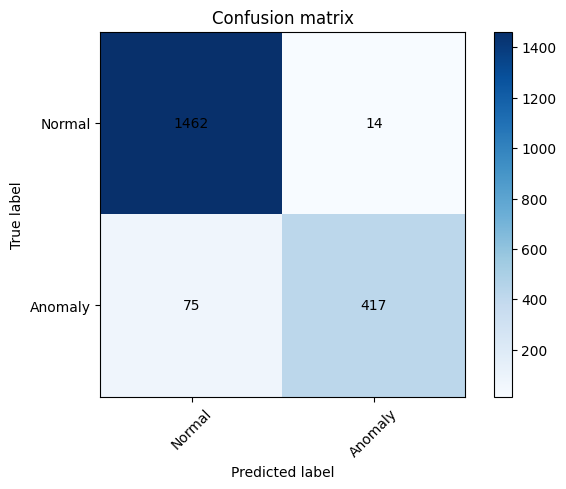

In [18]:
# Confusion Matrix
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

conf_matrix = confusion_matrix(y_test_combined, y_pred, labels=[0, 1])

plot_confusion_matrix(conf_matrix, ['Normal','Anomaly'])

This Confusion Matrix illustrates that the model correctly classified 1,369 normal transactions and 451 anomalies. 

However, it misclassified 107 normal transactions as anomalies (false positives) and failed to identify 41 anomalies (false negatives). The false positive rate is quite high, indicating that the model is overly conservative in labeling transactions as anomalies. 

To further evaluate the model, the **ROC curve** was also used.

The ROC (Receiver Operating Characteristic) curve is a graphical representation used to evaluate the performance of a binary classifier. It plots the True Positive Rate (sensitivity) against the False Positive Rate, showing the trade-off between correctly identifying positives and incorrectly classifying negatives.

A model with *high performance* will have a ROC curve that approaches the top-left corner, indicating a high True Positive Rate and a low False Positive Rate. The area under the ROC curve, known as **AUC**, quantifies overall performance: the closer the AUC is to 1, the better the model is at distinguishing between the classes.

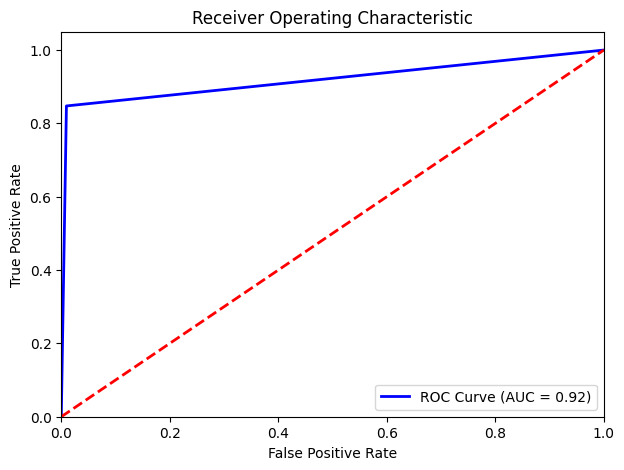

In [19]:
# ROC Curve
def plot_ROC (roc_auc):
    plt.figure(figsize=(7, 5))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC Curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

fpr, tpr, thresholds = roc_curve(y_test_combined, log_probs < threshold, pos_label=1)
roc_auc = auc(fpr, tpr)
plot_ROC(roc_auc)


With an AUC of 0.92, the ROC curve for the GMM model indicates reasonably good performance in distinguishing between normal and fraudulent transactions. 

## Autoencoder

<img src="https://www.assemblyai.com/blog/content/images/2022/01/autoencoder_architecture.png" alt="Autoencoder Structure" width="400"/>

An autoencoder is a type of neural network used for unsupervised learning that consists of two main parts: an encoder and a decoder. 

*   The **encoder** compresses the input data into a lower-dimensional latent space, capturing essential features in a "bottleneck" layer. 
*   The **decoder** then reconstructs the original data from this compressed representation, aiming to produce an output similar to the input.

In this model, the encoder starts with an input layer and progressively compresses the data through three dense layers, each followed by a small dropout layer to prevent overfitting. The latent (bottleneck) layer is a linear layer that represents the most compact encoding of the input data. The decoder mirrors the encoder structure, expanding the latent representation back to the original input dimension.

The final output layer produces a reconstructed version of the input data, which we compare to the original input to assess reconstruction quality. 


Another modification had to be made to the train set as it was too high in relation to the number of fraudulent examples in the test set.
In fact, as can be seen in the diagram below, the model was unable to identify the anomalies.

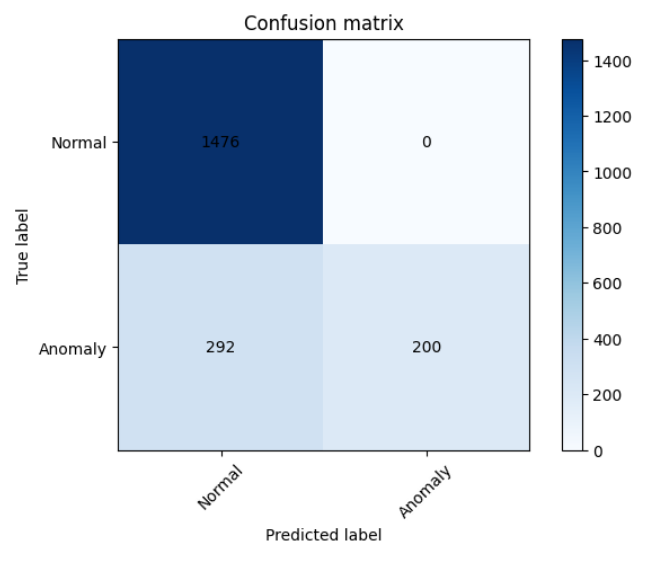

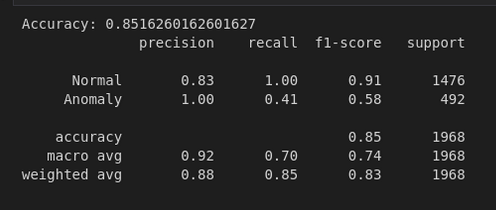



This is why it was decided to put a ratio of 10:1 (10 positive transactions for every fraudulent one).

In [20]:
X_train = X_train.sample((X_test.shape[0] * 10), random_state=42)
y_train = y_train.sample((X_test.shape[0] * 10), random_state=42)

print(X_train.shape)
print(y_train.shape)

(14760, 5)
(14760,)


In [21]:
# Model hyperparameters
input_dim = X_train.shape[1]

batch_size = 125
latent_dim = 5
max_epochs = 150
learning_rate = 0.0001

# Split in train and validation
X_train, X_validate = train_test_split(X_train, 
                                       test_size=0.3, 
                                       random_state=42)

### Encoder

- **Input Layer**: Accepts data with the specified `input_dim`.
- **Encoder Layers**: Three dense layers (64, 48, and 16 units) with `tanh` activation and dropout of 0.1.
- **Latent Layer**: A dense linear layer with `latent_dim` units representing the compressed encoding.

In [23]:
input_data = Input(shape=(input_dim,), name='encoder_input')

# Hidden layers
#encoder = Dense(units= 125, activation= 'tanh', name='encoder_1')(input_data)
#encoder = Dropout(.1)(encoder)
encoder = Dense(64,activation='tanh', name='encoder_2')(input_data)
encoder = Dropout(.1)(encoder)
encoder = Dense(48,activation='tanh', name='encoder_3')(encoder)
encoder = Dropout(.1)(encoder)
encoder = Dense(16,activation='tanh', name='encoder_4')(encoder)
encoder = Dropout(.1)(encoder)

# Bottleneck layer
latent_encoding = Dense(latent_dim, activation='linear', name='latent_encoding')(encoder)

In [24]:
encoder_model = Model(input_data, latent_encoding)

encoder_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_2 (Dense)               │ (None, 64)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_3 (Dense)               │ (None, 48)             │         3,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_4 (Dense)               │ (None, 16)             │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_encoding (Dense)         │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,373 (17.08 KB)

 Trainable params: 4,373 (17.08 KB)

 Non-trainable params: 0 (0.00 B)

### Decoder

- **Decoder Layers**: Four dense layers (16, 48, 64, and 125 units) with `tanh` activation and dropout of 0.1.
- **Output Layer**: A dense layer that reconstructs the input with a linear activation.

In [25]:
# The decoder network is a mirror image of the encoder network.
decoder = Dense(16, activation='tanh', name='decoder_1')(latent_encoding)
decoder = Dropout(.1)(decoder)
decoder = Dense(48, activation='tanh', name='decoder_2')(decoder)
decoder = Dropout(.1)(decoder)
decoder = Dense(64, activation='tanh', name='decoder_3')(decoder)
decoder = Dropout(.1)(decoder)
#decoder = Dense(125, activation='tanh', name='decoder_4')(decoder)
#decoder = Dropout(.1)(decoder)
                
# The output is the same dimension as the input data we are reconstructing.
reconstructed_data = Dense(units = input_dim, activation='linear', name='reconstructed_data')(decoder)

In [26]:
autoencoder_model = Model(input_data, reconstructed_data)

autoencoder_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_2 (Dense)               │ (None, 64)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_3 (Dense)               │ (None, 48)             │         3,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_4 (Dense)               │ (None, 16)             │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_encoding (Dense)         │ (None, 5)              │            85 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_1 (Dense)               │ (None, 16)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_2 (Dense)               │ (None, 48)             │           816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_3 (Dense)               │ (None, 64)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reconstructed_data (Dense)      │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,746 (34.16 KB)

 Trainable params: 8,746 (34.16 KB)

 Non-trainable params: 0 (0.00 B)

The dropout layers are added since the model will performe much worse without:

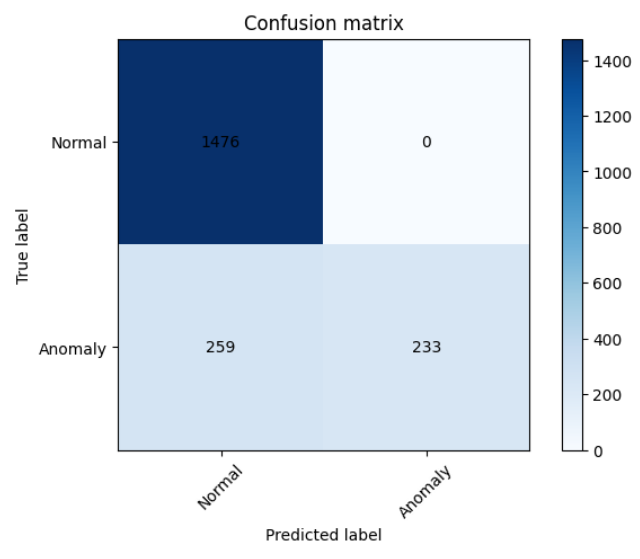

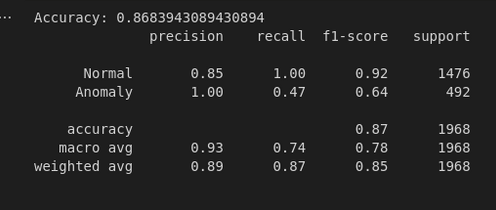


The **Adam optimizer** with an adaptive learning rate is chosen for its efficiency and rapid convergence capabilities, while the **MSE loss function** penalizes discrepancies in reconstructions, improving model quality. 

**Early stopping** monitors validation loss to prevent overfitting, terminating training if no improvements are observed for 5 epochs and restoring optimal weights.

In [27]:
# Optimizer
opt = optimizers.Adam(learning_rate=learning_rate)
autoencoder_model.compile(optimizer=opt, loss='mse', metrics=['accuracy'])

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [28]:
# Train the model
train_history = autoencoder_model.fit(X_train, X_train,
        shuffle=True,
        epochs=max_epochs,
        batch_size=batch_size,
        validation_data=(X_validate, X_validate),
        callbacks=early_stopping)

Epoch 1/150
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3210 - loss: 0.8047 - val_accuracy: 0.5743 - val_loss: 0.5152
Epoch 2/150
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5305 - loss: 0.5888 - val_accuracy: 0.6942 - val_loss: 0.3540
Epoch 3/150
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6392 - loss: 0.4169 - val_accuracy: 0.8243 - val_loss: 0.2375
Epoch 4/150
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7151 - loss: 0.3357 - val_accuracy: 0.9192 - val_loss: 0.1689
Epoch 5/150
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7597 - loss: 0.2842 - val_accuracy: 0.9266 - val_loss: 0.1522
Epoch 6/150
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7658 - loss: 0.2896 - val_accuracy: 0.9370 - val_loss: 0.1434
Epoch 7/150
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7881 - loss: 0.2892 - val_accuracy: 0.9365 - val_loss: 0.1325
Epoch 8/150
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7721 - loss: 0.2549 - val_accuracy: 0.9420 - v

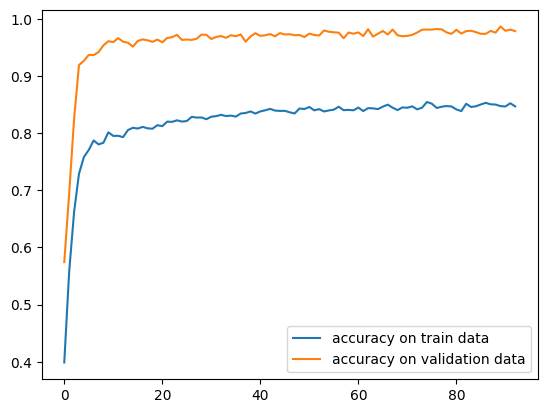

In [29]:
plt.plot(train_history.history['accuracy'])
plt.plot(train_history.history['val_accuracy'])
plt.legend(['accuracy on train data', 'accuracy on validation data'])

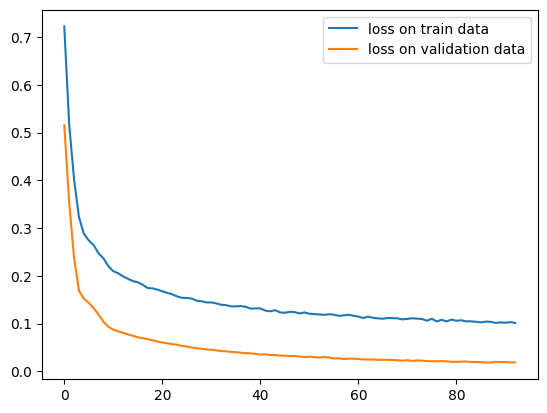

In [30]:
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.legend(['loss on train data', 'loss on validation data'])

 The trained autoencoder model is now used to reconstruct the input data from X_test_combined using the `predict` method.
 
 The reconstruction scores are then calculated as the mean squared error (MSE) between the original input and its reconstruction.
 
 This scores are then stored in a Pandas DataFrame called `anomaly_data`, which includes a column for the reconstruction scores and a column labeled 'binary_labels' that adds the corresponding labels from y_test_combined, allowing for analysis of anomalies against normal instances.

In [31]:
# Reconstruct the data using our trained autoencoder model
x_test_recon = autoencoder_model.predict(X_test_combined)

# The reconstruction score is the mean of the reconstruction errors (relatively high scores are anomalous)
reconstruction_scores = np.mean((X_test_combined - x_test_recon)**2, axis=1)

# Store the reconstruction data in a Pandas dataframe
anomaly_data = pd.DataFrame({'recon_score':reconstruction_scores})

# Add the binary labels to our anomaly dataframe
anomaly_data['binary_labels'] = y_test_combined


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [32]:
# Use the optimal threshold
optimal_threshold_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_threshold_idx]

y_pred = (reconstruction_scores > optimal_threshold).astype(int)

In [33]:
# Evaluation of the performance
if len(y_test_combined) == len(y_pred):
    print("Accuracy:", accuracy_score(y_test_combined, y_pred))
    CLASS_NAMES = ['Normal', 'Anomaly']   
    print(classification_report(y_test_combined, y_pred, target_names=CLASS_NAMES))
else:
    print("Error: The number of samples in y_test_fraud and y_pred does not match.")
    print(len(y_test_combined))
    print(len(y_pred))

Accuracy: 0.9502032520325203
              precision    recall  f1-score   support

      Normal       0.94      1.00      0.97      1476
     Anomaly       0.98      0.82      0.89       492

    accuracy                           0.95      1968
   macro avg       0.96      0.91      0.93      1968
weighted avg       0.95      0.95      0.95      1968



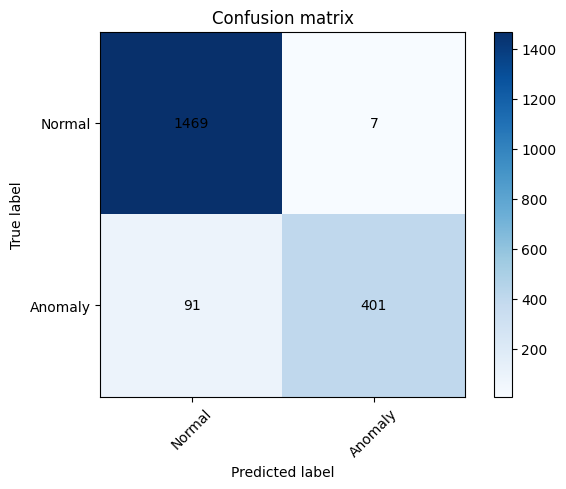

In [34]:
# Confusion matrix
results = confusion_matrix(y_test_combined, y_pred)
plot_confusion_matrix(results, ['Normal','Anomaly'])

The autoencoder shows a strong ability to classify normal transactions accurately, with 1,469 true negatives and only 7 false positives. 

This low false positive rate is an improvement, meaning the model is more precise in distinguishing normal transactions without generating many unnecessary alerts. 

However, the model misclassified 91 anomalies as normal transactions (false negatives), which could allow some fraudulent cases to go undetected.

In summary, compared to the previous model, the autoencoder achieved a lower false positive rate and a slightly higher false negative rate. 

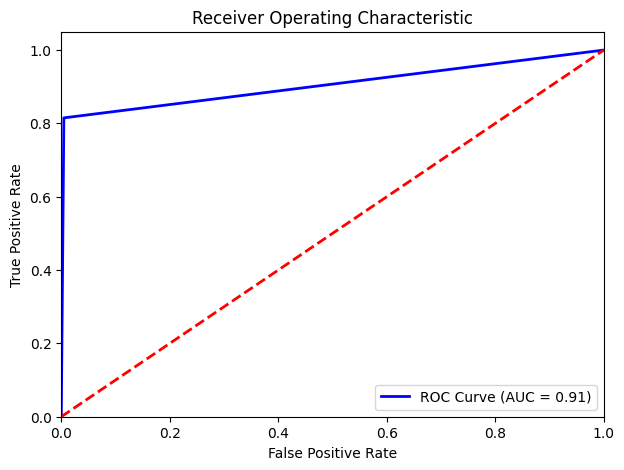

In [35]:
#ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_combined, y_pred)
roc_auc = auc(fpr, tpr)

plot_ROC(roc_auc)

It is possible to see the this ROC curve has a better behavior than the GMM's, since it has a AUC of 0.91, which reflects strong model performance in distinguishing between the two classes.

## Conclusions

In summary, two anomaly detection techniques were analyzed and compared in this project: the Gaussian Mixture Model (GMM) and the Autoencoder. Both models have shown good results in identifying fraudulent transactions, but there were differences in their performance.

-   The **GMM** demonstrated a strong capability for anomaly detection, achieving an average accuracy of 95.5% on the test data. This model effectively captured the data distribution, allowing it to detect anomalies reliably. Notably, GMM also showed a superior trade-off between false positives and false negatives compared to the Autoencoder, which is essential for minimizing costly false alarms in fraud detection.

-   On the other hand, the **Autoencoder** achieved a slightly lower accuracy of 95%. While its architecture offers flexibility, the model’s complexity did not translate to higher accuracy. Additionally, the Autoencoder’s false positive-to-false negative ratio was less balanced than GMM's, impacting its overall reliability in this context.

-   In terms of the **Area Under the Curve (AUC)** of the ROC curve, the GMM achieved a slightly higher value (AUC = 0.92) compared to the Autoencoder (AUC = 0.91), indicating a marginally better overall ability to distinguish between fraudulent and non-fraudulent transactions.


Overall, the results suggest that the <u>GMM</u> s a slightly more effective choice for fraud detection in this context, providing a better balance between accuracy and the cost of misclassifications. This makes it a robust option when prioritizing both detection precision and manageable false alarm rates.

### Further improvements

As a possible further development of the subject, the following topics could be approached:
*   **Dataset managing**: as has been pointed out previously the dataset has been simplified, both in the choice of components to be used and in the rationalization (caused by the imbalance of the two classes). So a possible development might be:
    *    to increase the number of components of the simplified dataset, if not use it in its entirety;
    *    to use synthetic data (_data augmentation_) to create more fraudulent data .
  
*   **Different Autoencoder'structure or hyperparameters**: the autoencoder can be setted with different hyperparameters or built with a different structure (more layer, different activation, more/less neurons, ...)
  
*   **Choose different models for Anomaly Detection**
